In [1]:
import csv 
import numpy as np
import pandas as pd
import sys
import platform
system = platform.system()
if system =='Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
elif system =='Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
path2curve = 'Battery 9 (RIP)/Discharge 200mA/SOCvsOCV_discharge200mA.csv'
curve = OCVcurve(path2curve)

### Import the test file

In [3]:
if system == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/KF Testing/jMAVSim/'
elif system == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/Donald Trump/'
    
log_file = analog.pathfromQGC(folder,index=107)

print(log_file)
info = analog.logextract(log_file,['battery_status','vehicle_local_position'])
print(info.keys())

# From battery_status
current = info['battery_current']
current_filtered = info['battery_filtered_current']
SOC = info['remaining']
time = info['time_bs']
n_cells = info['n_cells']
voltage = info['battery_voltage']/n_cells

# From battery_status_ekf
SOC_ekf = info['remaining_ekf']
kalman_gain = info['kalman_gain']
kalman_gain = np.squeeze(kalman_gain)
covx = info['covx']
innovation = info['innovation']
iR1 = info['iR1']

# discard timestamps with non-initalized battery
current = current[voltage>0]
current_filtered = current_filtered[voltage>0]
SOC = SOC[voltage>0]
time = time[voltage>0]
kalman_gain = kalman_gain[:,voltage>0]
covx = covx[:,:,voltage>0]
innovation = innovation[voltage>0]
iR1 = iR1[voltage>0]
voltage = voltage[voltage>0] # to be done at the end
print(len(time))

# From vehicle_local_position
x = info['x']
y = info['y']
z = info['z']
time_vlp = info['time_vlp']

/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/Donald Trump//log_107_2019-11-13-14-10-02.ulg
dict_keys(['time_vlp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'covx', 'kalman_gain', 'innovation', 'iR1', 'time_bs', 'n_cells', 'battery_current', 'battery_filtered_current', 'battery_voltage', 'battery_filtered_voltage', 'discharged_mah', 'remaining'])
3468


# Kalman filter analysis

<IPython.core.display.Javascript object>


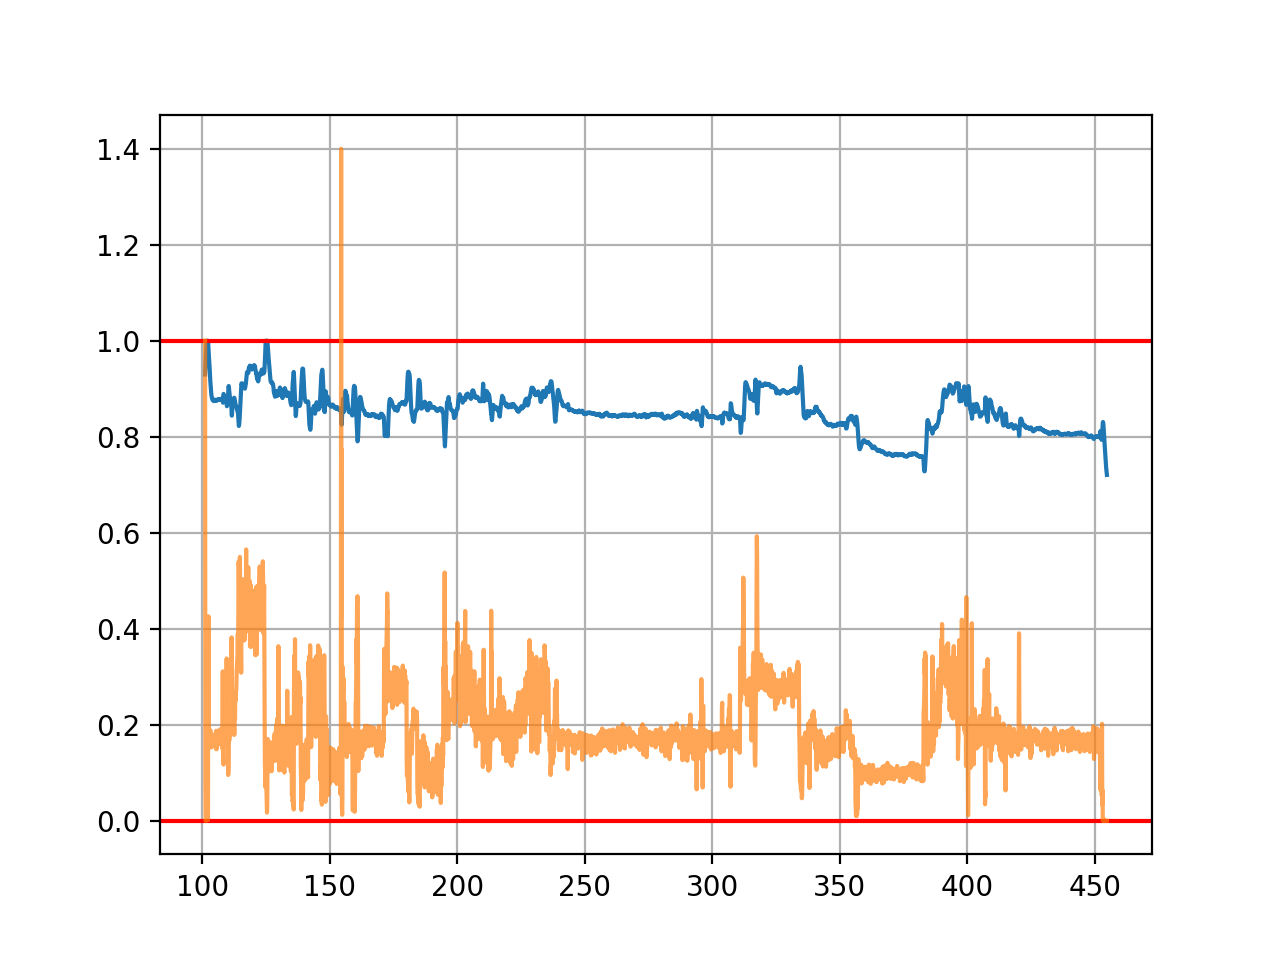

In [4]:
%matplotlib notebook
plt.figure()
plt.plot(time,SOC)
plt.axhline(0,color='r')
plt.axhline(1,color='r')
plt.plot(time,current/current[0],alpha=.7)
plt.grid()
plt.show()

# Simulation


In [5]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.002
R1 = float(ECparams['R1'])
R1 = 0.02
C1 = float(ECparams['C1'])
C1 = 300
print([R0,R1,C1])

[0.002, 0.02, 300]


### Tune some more simulation parameters

In [6]:
Q = 6500*3.6 # has to be in Coulombs
eta = 1
z0 = SOC[0]
print(f'z0 = {z0}')
battery = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.9297209978103638


### Run the simulation using the state-space model

In [7]:
xhat0 = np.array([[SOC[0]],[iR1[0]]]) # is a stack of 2x1 arrays = a 2xk array
covx0 = np.array([[0.3,0.],[0., .1]]) # is a stack of 2x2 arrays

covw = np.array([[5e-2, 0.],[0., 1e-5]]) # is a constant 2x2 array
covv = 0.5017 # is a constant 1x1 array

yhat = np.array([]) # is a stack of 1x1 arrays = a 1-D array
xhat = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covxy = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covy = np.array([]) # is a stack of 1x1 arrays = a 1-D array
L = np.array([]) # is a stack of stack of 2x1 arrays = a 1-D array

u = current # is a stack of 1x1 arrays = a 1-D array
y = voltage # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

In [8]:
n = len(time-1)
for k in range(len(y[:n+1])):
    #print(f'\n New iteration k={k}')
    
    if k == 0: 
        kfbat.reset(R0,R1,C1,xhat0[0])
    else: 
        kfbat.reset(R0,R1,C1,xhat[0,k-1])
    kfbat.statespace(np.mean(np.diff(time)))
    
    # 1 : Prediction update
    
    # 1c : Output predicition
    
    if k==0: 
        yhat = kfbat.OCVcurve.OCVfromSOC(xhat0[0]) - R1*xhat0[1]
    else : 
        yhat = np.concatenate([yhat,kfbat.OCVcurve.OCVfromSOC(xhat[0,k-1]) - R1*xhat[1,k-1] + kfbat.D*u[k-1]])
    
    inno = y[k] - yhat[k]
    
    if inno > 0.05:
        inno = 0.05
    elif inno < -0.05:
        inno = -0.05
            
    #print(f'Innovation : {inno}')
    
    
    # 1b State covariance a priori
    
    if k==0 :
        covx = kfbat.A@covx0@kfbat.A.T + covw
    elif k==1: 
        covx = np.dstack([covx,kfbat.A@covx@kfbat.A.T + covw])
    else :
        covx = np.dstack([covx,kfbat.A@covx[:,:,-1]@kfbat.A.T + covw])

    if k==0:
        covxy = np.reshape(covx@kfbat.C.T,(2,1))
        covy = np.reshape(kfbat.C@covx@kfbat.C.T + covv,1)
        np.reshape(covx@kfbat.C.T,(2,1))
    else : 
        covxy = np.concatenate([covxy,np.reshape(covx[:,:,k]@kfbat.C.T,(2,1))],axis=1)
        #print(f'covxy is {np.shape(covxy)}, should be {2,k+1}')
        #print(np.shape(kfbat.C@covx[:,:,k]@kfbat.C.T + covv))
        covy = np.concatenate([covy,np.reshape(kfbat.C@covx[:,:,k]@kfbat.C.T + covv,1)])
    
    L = covxy/covy
    #print(f'covy is {np.shape(covy)}, should be {k+1}')
    
    #print(f'covxy = {covxy[:,k]}')      
    #print(f'Lk={np.reshape(L[:,-1],(2,1))}')
    
    #print(f'L is {np.shape(L)}, should be 2x{k+1}')
    
    # 1a & 2b State estimate prediction and correction
    
    if k==0:
        xhat = xhat0
        #print(f'xhat is {np.shape(xhat)}, should be 2x{k+1}')
    else : 
        alpha = np.reshape(kfbat.A@xhat[:,k-1],(2,1))
        beta = kfbat.B*u[k-1]
        xhat = np.concatenate([xhat,np.reshape(alpha + beta,(2,1)) + np.reshape(L[:,k]*inno,(2,1))],axis=1)
        # xhat = np.concatenate([xhat,np.reshape(xhat[:,k],(2,1)) + np.reshape(kalman_gain[:,k]*innovation[k],(2,1))],axis=1)
        # print(f'xhat is {np.shape(xhat)}, should be 2x{k+1}')
        if xhat[0,k] > 1.0:
            xhat[0,k] = 1.0
        elif xhat[0,k] < 1e-3:
            xhat[0,k] = 1e-3
    
    # 2c State covariance a posteriori 
    if k==0: 
          covx = covx - L*kfbat.C@covx
    else :
        covx = np.dstack([covx,covx[:,:,k] - L[:,k]*kfbat.C@covx[:,:,-1]])
        #print(covx[:,:,k])
    #print(f'covx is {np.shape(covx)}, should be 2x2x{k+1}')    
    

## Comparison of Kalman filter results with firmware ones

<IPython.core.display.Javascript object>


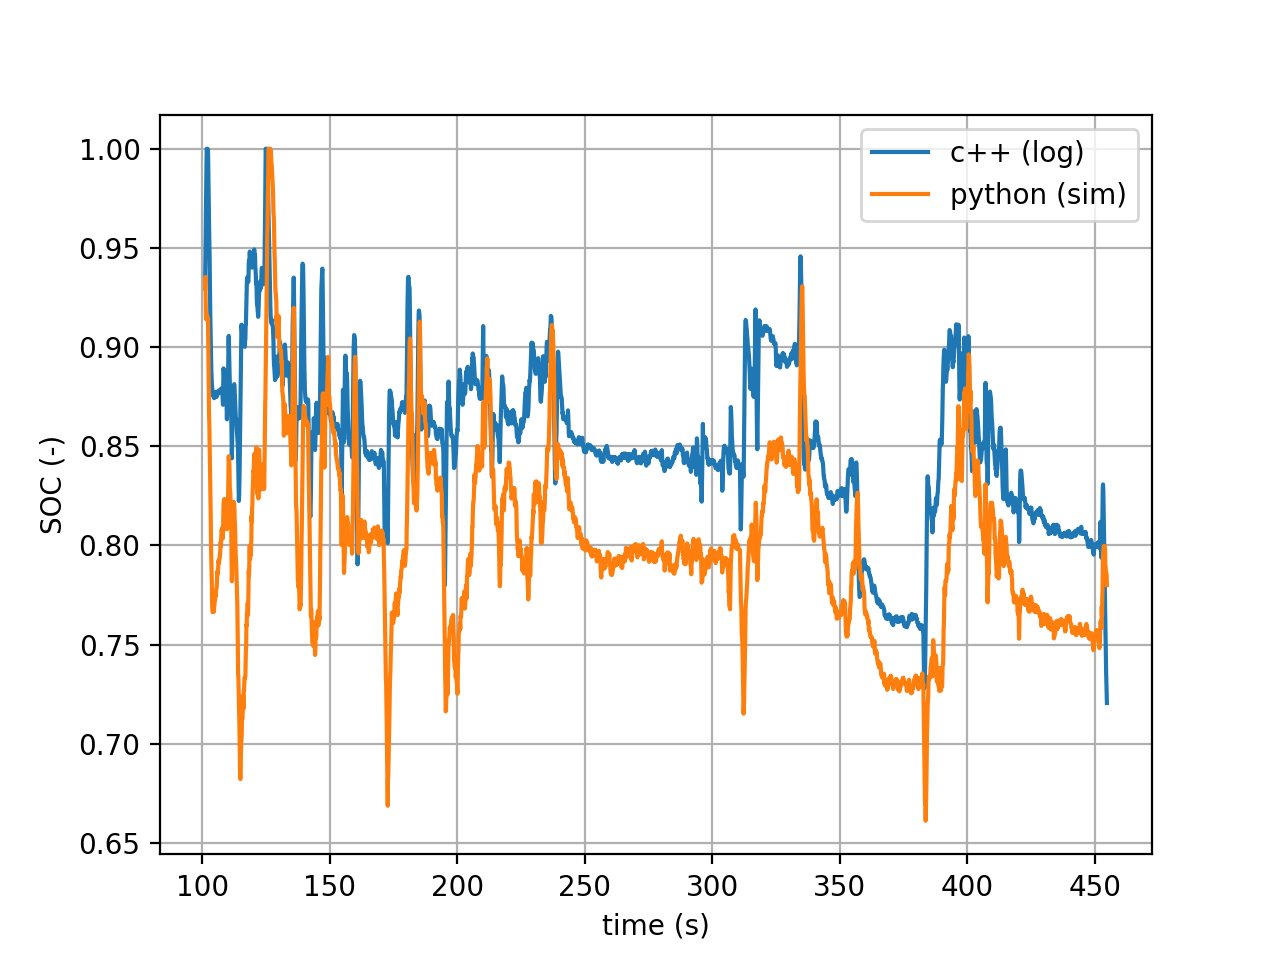

In [9]:
plt.figure()
plt.plot(time,SOC,label='c++ (log)')
plt.plot(time[:n+1],xhat[0,:],label='python (sim)')
#plt.plot(time[:n+1],xhat[0,:]+covxhat[0,0,:],linestyle=':',color='C1')
#plt.plot(time[:n+1],xhat[0,:]-covxhat[0,0,:],linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.legend()
plt.grid()
plt.title

<IPython.core.display.Javascript object>


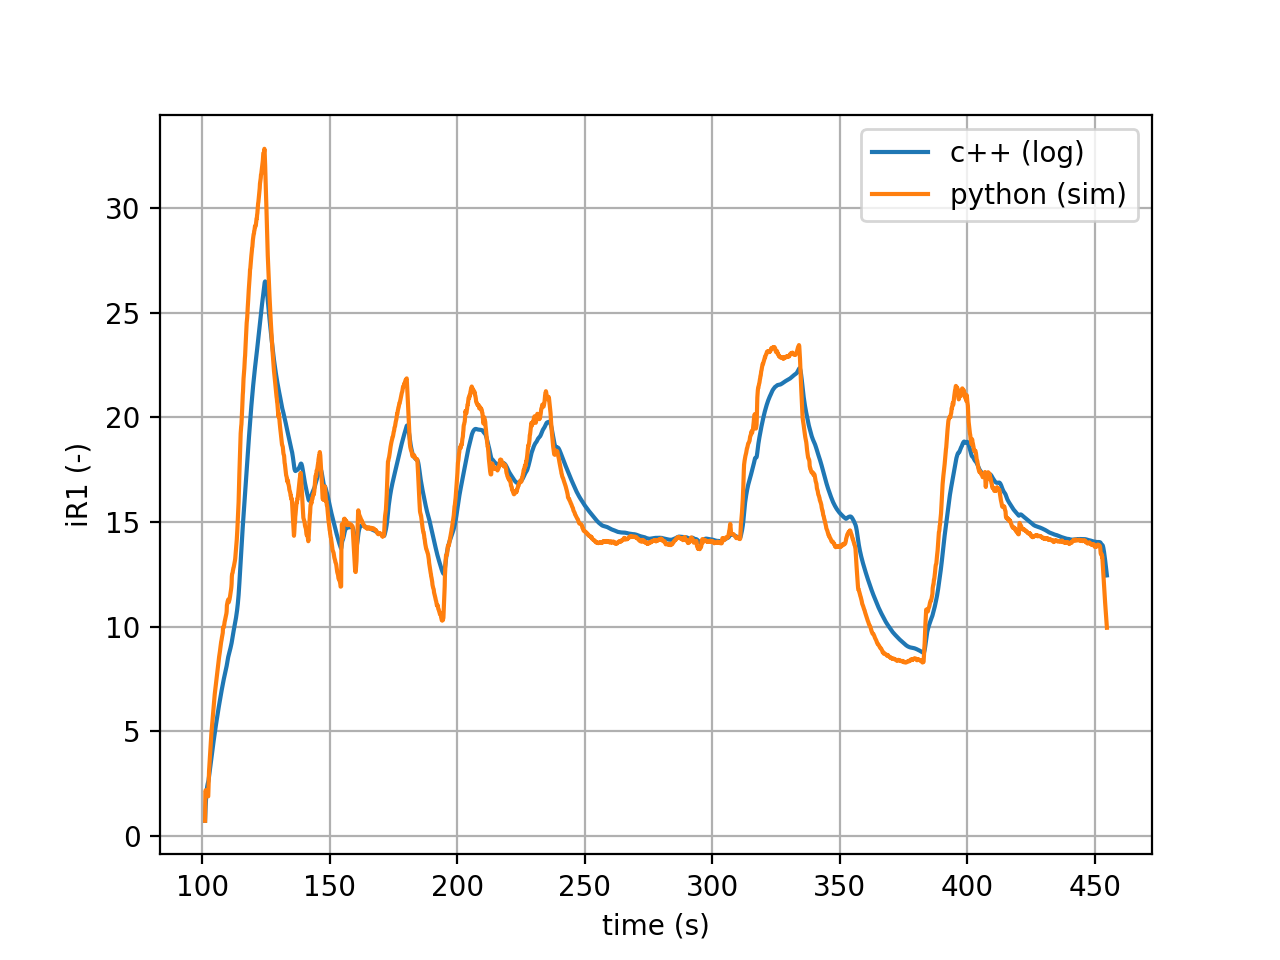

In [10]:
plt.figure()
plt.plot(time,iR1,label='c++ (log)')
plt.plot(time[:n+1],xhat[1,:],label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('iR1 (-)')
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


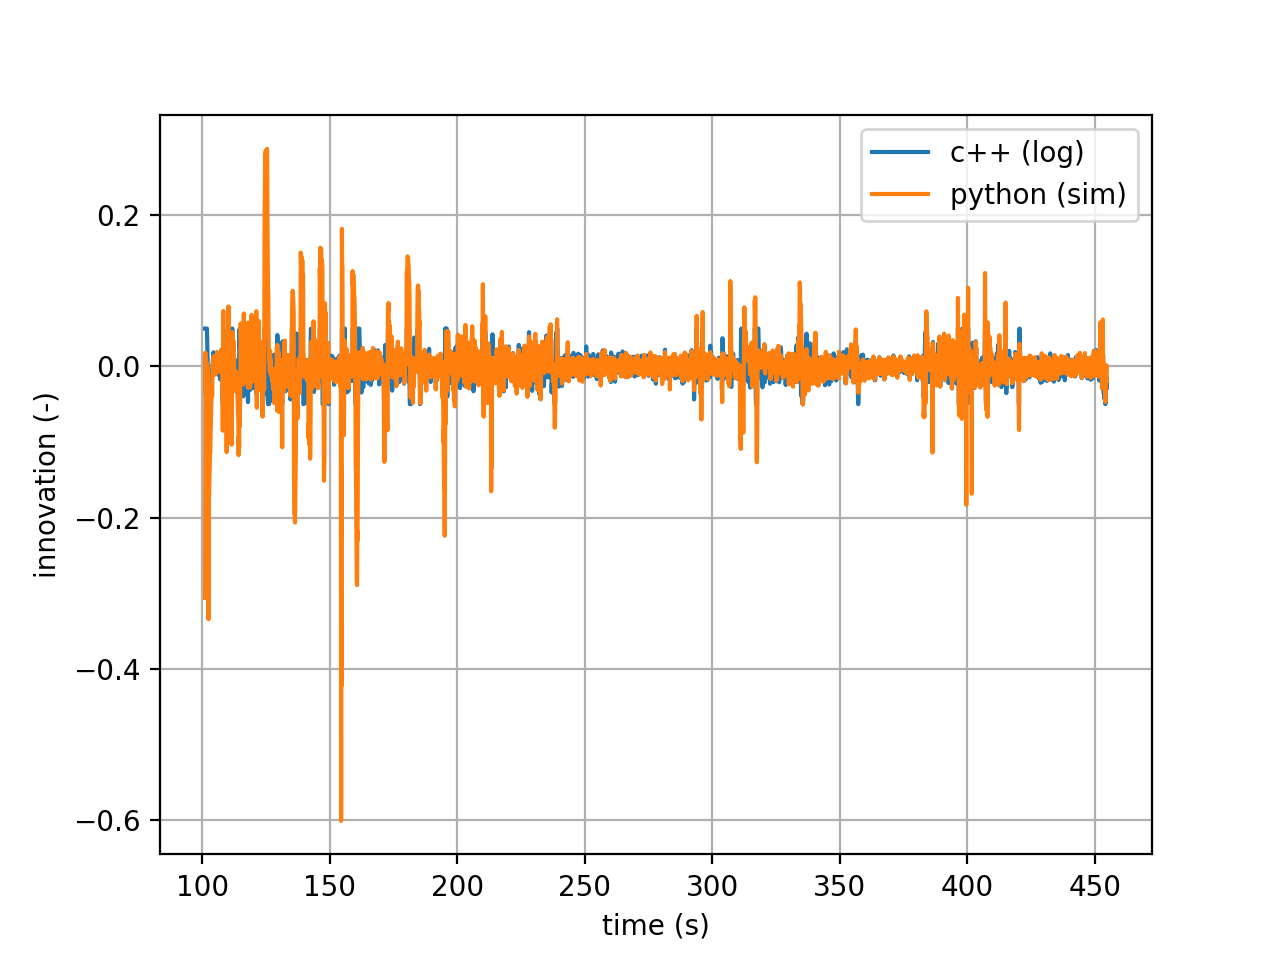

In [11]:
plt.figure()
plt.plot(time,innovation,label='c++ (log)')
plt.plot(time[:n+1],y-yhat,label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('innovation (-)')
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


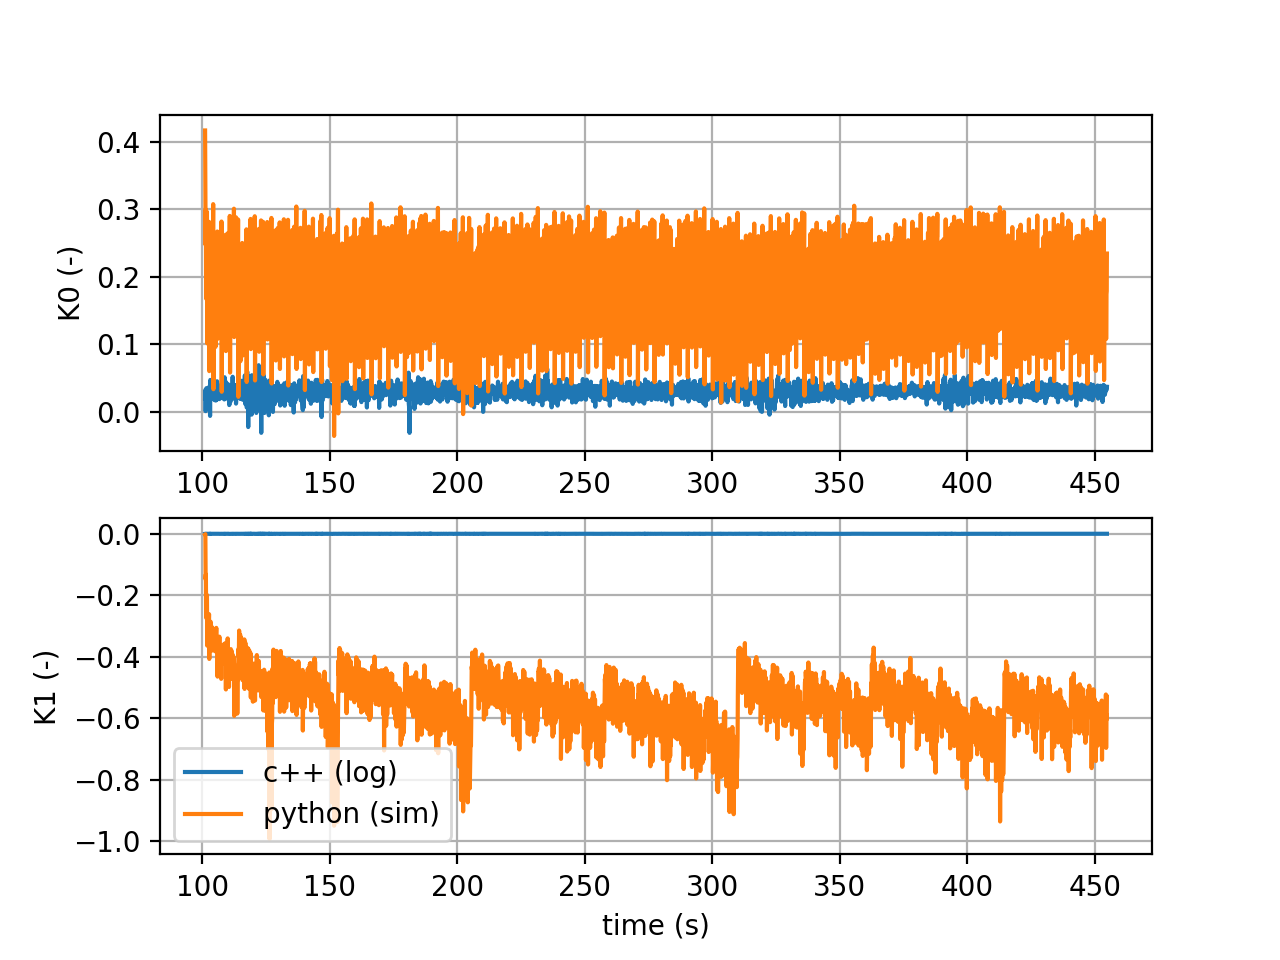

In [12]:
plt.figure()
plt.subplot(211)
plt.plot(time,kalman_gain[0,:],label='c++ (log)')
plt.plot(time[:n+1],L[0,:],label='python (sim)')
plt.grid()
plt.ylabel('K0 (-)')
plt.subplot(212)
plt.plot(time,kalman_gain[1,:],label='c++ (log)')
plt.plot(time[:n+1],L[1,:],label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('K1 (-)')
plt.legend()
plt.grid()